In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [110]:
import numpy as np
import pandas as pd
from nltk.tokenize import WordPunctTokenizer
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding, LSTM,Dense, Dropout, Activation
from keras.models import load_model,Sequential, Model
from keras import models
from keras import layers
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, TransformerMixin
from keras import callbacks
import nltk
nltk.download('punkt')
nltk.download('wordnet')

from numpy import loadtxt
from keras.models import load_model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
train_images_list = os.listdir('/content/drive/My Drive/data/flickr1k/images')
doc = pd.read_csv('/content/drive/My Drive/data/flickr1k/captions.csv')
doc.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [0]:
class CleanText(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
      self.reviews=[]
      self.tokenizer = WordPunctTokenizer()
      self.lemmatizer = WordNetLemmatizer()
      self.twitter_handle = r'@[A-Za-z0-9_]+'                        
      self.url_handle = r'http[^ ]+'                                  
      self.combined_handle = r'|'.join((self.twitter_handle,self.url_handle))  
      self.www_handle = r'www.[^ ]+'                                 
      self.punctuation_handle = r'\W+'
      return self
    def clean(self,texts):  
      for sent in tqdm(texts):
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
        cleaned_text = re.sub(self.punctuation_handle, " ",(re.sub(self.www_handle, '', re.sub(self.combined_handle, '',review_text)).lower()))
    
        words = word_tokenize(cleaned_text.lower())

    
        #lemmatize each word to its lemma
        lemma_words = [self.lemmatizer.lemmatize(i,pos='v') for i in words]
        cleaned_text = ' '.join([word for word in lemma_words])
        cleaned_text=(" ".join([word for word in self.tokenizer.tokenize(cleaned_text) if len(word) > 1])).strip()
        self.reviews.append(cleaned_text)    
      return(pd.DataFrame(self.reviews))
    def transform(self, X, y=None):
      return self.clean(X)

In [0]:
pipe_preprocess = Pipeline([
    ('normalizer', CleanText()),
])

In [115]:
doc.caption=pipe_preprocess.fit_transform(doc.caption)
doc.head()

100%|██████████| 5000/5000 [00:02<00:00, 2028.56it/s]


,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress be climb up set of stairs ...
1,1000268201_693b08cb0e.jpg,girl go into wooden build
2,1000268201_693b08cb0e.jpg,little girl climb into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climb the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress go into wooden cabin


In [116]:
vocab=list(doc.caption)
vocab=set(vocab)
vocab=" ".join(vocab)
print(vocab)
vocab=set(vocab.split(" "))
vocab=list(vocab)
len(vocab)

football player wear green jersey with the number on it young boy cover in grass jump near wooden fence two young fair girls be smile pose together while they ride in boat wear floatation vest four children be have pillow fight girl sit on top of crocodile man be play guitar with child play harmonica while three young girls watch man set up camp after canoe two men and some horse on snowy mountain frighten little boy be pull up and out of pool by his father child do handstand on the beach man in blue tank top show his invention girl in red top bowl cricket ball at boy in yellow shirt who be in front of the wicket hold bat black dog the black dog war red collar be run through the water with ball in its mouth dog run in shrubbery along stream the little girl in the strip shirt be eat some bread young boy in blue jacket pull something black out of fabric bag stand man on phone with seat woman write near artist outdoor display the legs and mid section of two people with skateboard man in a

2503

In [0]:
all_img= os.listdir('/content/drive/My Drive/data/flickr1k/images')



In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [0]:
model.save("incep.h5")

In [0]:
model=load_model("incep.h5")

In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess('/content/drive/My Drive/data/flickr1k/images/'+image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [124]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in all_img:
    encoding_train[img] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 267.2325990200043


In [125]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
def encode1(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec
start = time()
encoding_test= {}
encoding_test[1] = encode1("download.jpg")
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.26288604736328125


In [0]:
import pickle

In [0]:
# Save the bottleneck test features to disk
with open("/content/drive/My Drive/data/flickr1k/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
# Save the bottleneck train features to disk

with open("/content/drive/My Drive/data/flickr1k/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [129]:
train_features = load(open("/content/drive/My Drive/data/flickr1k/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1000


In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [131]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2504

In [0]:
big_sen=list(doc.caption)
max_length=max(len(d.split()) for d in big_sen)



In [133]:
doc.head()

,image,caption
0,1000268201_693b08cb0e.jpg,child in pink dress be climb up set of stairs ...
1,1000268201_693b08cb0e.jpg,girl go into wooden build
2,1000268201_693b08cb0e.jpg,little girl climb into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climb the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress go into wooden cabin


In [0]:
from collections import defaultdict
description = defaultdict(list)
d= [description[i].append(a) for i, a, in zip(doc.image, doc.caption)]
description=dict(description) 

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [136]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/data/flickr1k/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [138]:
embedding_matrix.shape

(2504, 200)

In [0]:
def mod_def():
  inputs1 = Input(shape=(2048,))
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  inputs2 = Input(shape=(max_length,))
  se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
  se2 = Dropout(0.5)(se1)
  se3 = LSTM(256)(se2)
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.layers[2].set_weights([embedding_matrix])
  model.layers[2].trainable = False
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model


In [140]:
mode=mod_def()
mode.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 29, 200)      500800      input_12[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2048)         0           input_11[0][0]                   
____________________________________________________________________________________________

In [0]:
#!unzip -uq "/content/drive/My Drive/data/flickr1k/glove.6B.200d.txt.zip" -d "/content/drive/My Drive/data/flickr1k/"


In [0]:
epochs = 3
number_pics_per_bath = 3
steps = len(description)//number_pics_per_bath

In [143]:
for i in range(epochs):
    generator = data_generator(description, train_features, wordtoix, max_length, number_pics_per_bath)
    mode.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('i.h5')

Epoch 1/1
333/333 [==============================] - 121s 362ms/step - loss: 5.5140
Epoch 1/1
333/333 [==============================] - 123s 369ms/step - loss: 4.5370
Epoch 1/1
333/333 [==============================] - 119s 358ms/step - loss: 4.1070


In [0]:
mode.save('i.h5')

In [145]:
!mkdir saved_model

mkdir: cannot create directory ‘saved_model’: File exists


In [0]:
mode.save('saved_model/my_model') 

In [0]:
mode.load_weights('i.h5')

In [0]:
images = 'downlad.jpg'

In [0]:
with open("/content/drive/My Drive/data/flickr1k/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
sequence=[]
def greedySearch(photo):
    global sequence
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        sequence=np.array(sequence).astype('float32')
        #print(sequence)

        #print(sequence)
        yhat = mode.predict([photo,sequence], verbose=0)
        #print(yhat.shape)
        yhat = np.argmax(yhat)
        
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq' or len(in_text.split(" "))>15:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

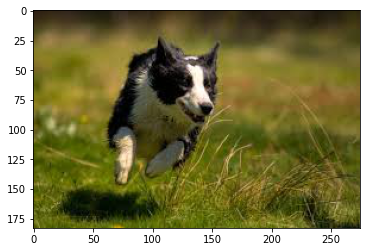

Greedy: dog be run through the grass with his mouth in the water and his
[[0.20301072 0.2512903  0.03320545 ... 0.06745181 0.47044635 0.25491905]]


In [151]:
z=0

pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread("download.jpg")
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(image)

In [152]:
"""new_model= tf.keras.models.load_model(filepath="i.h5")
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model)
# Load TFLite model and see some details about input/output

interpreter = tf.lite.Interpreter("tf_lite_model.tflite")
#tflite_interpreter.resize_tensor_input(output_details[0]['index'], (1,2504))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

"""

'new_model= tf.keras.models.load_model(filepath="i.h5")\ntflite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)\ntflite_model = tflite_converter.convert()\nopen("tf_lite_model.tflite", "wb").write(tflite_model)\n# Load TFLite model and see some details about input/output\n\ninterpreter = tf.lite.Interpreter("tf_lite_model.tflite")\n#tflite_interpreter.resize_tensor_input(output_details[0][\'index\'], (1,2504))\ninterpreter.allocate_tensors()\ninput_details = interpreter.get_input_details()\noutput_details = interpreter.get_output_details()\n\n'

In [0]:
new_model = tf.keras.models.load_model('saved_model/my_model')


In [154]:
!mkdir "tflite_models"

mkdir: cannot create directory ‘tflite_models’: File exists


In [0]:
TFLITE_MODEL = "tflite_models/caption.tflite"


In [162]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x,y : new_model([x,y]))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(mode.inputs[0].shape, mode.inputs[0].dtype),
    tf.TensorSpec(mode.inputs[1].shape, mode.inputs[1].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
"""
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh"""

'\n# Convert the model to quantized version with post-training quantization\nconverter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])\nconverter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]\ntflite_quant_model = converter.convert()\nopen(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)\n\nprint("TFLite models and their sizes:")\n!ls "tflite_models" -lh'

In [180]:
# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("name:", input_details[1]['name'])
print("shape:", input_details[1]['shape'])
print("type:", input_details[1]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [   1 2048]
type: <class 'numpy.float32'>
name: y
shape: [ 1 29]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: []
type: <class 'numpy.float32'>


In [0]:
input_shape = input_details[0]['shape']
x=np.random.random_sample(input_shape)

input_data = tf.convert_to_tensor(x, dtype=np.float32)
tflite_interpreter.set_tensor(input_details[0]['index'], input_data)


In [0]:
input_shape = input_details[1]['shape']
y=np.random.random_sample(input_shape)
input_data =tf.convert_to_tensor(y, dtype=np.float32)

tflite_interpreter.set_tensor(input_details[1]['index'], input_data)


In [186]:


tflite_interpreter.invoke()

RuntimeError: ignored